In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import datetime
import pickle
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lgjel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lgjel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lgjel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# 1. Load data
base_dir = r'C:\Users\lgjel\Desktop\Course\6. Jan 2025 Term\ISSS609 Text Analytics & Applications\Group Project'
df = pd.read_csv(f"{base_dir}/Reviews.csv")

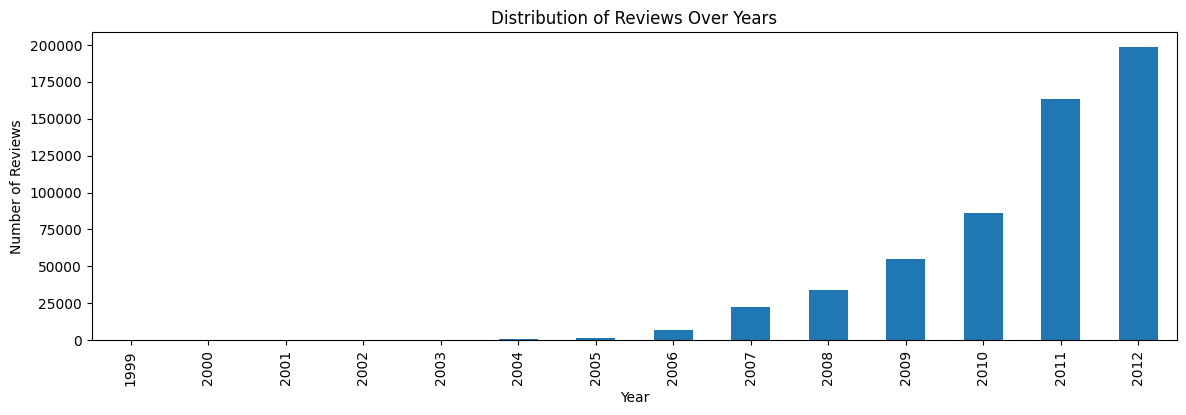

In [3]:
# 2. Data Cleaning
df['DateTime'] = pd.to_datetime(df['Time'], unit='s')
plt.figure(figsize=(14, 4))
df['DateTime'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Reviews Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(False)
plt.show()

In [4]:
null_text = df['Text'].isnull().sum()
duplicate_text = df.duplicated(subset='Text').sum()
df['TextLength'] = df['Text'].str.len()
comment_length_stats = df['TextLength'].describe()

In [5]:
# Remove duplicates and filter by date
df = df.drop_duplicates(subset='Text')
df = df[df['DateTime'].dt.year >= 2006]

def word_count(text):
    return len(text.split())

df['WordCount'] = df['Text'].apply(word_count)
df = df[(df['WordCount'] >= 10) & (df['WordCount'] <= 500)]
df_sample = df
print("Max word count:", df_sample['WordCount'].max())

Max word count: 500


In [6]:
# 3. Text Preprocessing - Experiment 1
topic_stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def topic_preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove non-alphanumeric characters 
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    tokens = [w for w in tokens if w not in topic_stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # Rejoin
    return " ".join(tokens)

df_sample['Processed_Text1'] = df_sample['Text'].apply(topic_preprocess)

In [7]:
# 4. Text Preprocessing - Experiment 2
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Replace all types of punctuation/characters with a space
    text = re.sub(r'[^\w\s]', ' ', text)
    # Replace any form of white space with a single space
    text = re.sub(r'\s+', ' ', text)
    # Tokenize the text
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    # Define custom stopwords
    custom_stop_words = ['get', 'got', 'make', 'one', 'product', 'would', 'really', 'also', 'even', 'since', 'never', 'ive', 'per', 'dont', 'ya', 'etc', 'ever']
    all_stop_words = set(stopwords.words('english')).union(custom_stop_words)
    # Remove stopwords and filter out short words
    words = [word for word in words if word not in all_stop_words and len(word) > 2]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words into a processed string
    return ' '.join(words)


df_sample['Processed_Text2'] = df_sample['Text'].apply(preprocess_text)

In [8]:
# Token lists for coherence/diversity
tokens_1 = df_sample['Processed_Text1'].apply(str.split)
tokens_2 = df_sample['Processed_Text2'].apply(str.split)

In [9]:
# 5 & 6. Vectorization using CountVectorizer
vectorizer_1 = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X1 = vectorizer_1.fit_transform(df_sample['Processed_Text1'])

vectorizer_2 = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X2 = vectorizer_2.fit_transform(df_sample['Processed_Text2'])

In [10]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

In [11]:
# # 7 & 8. LDA Training + Perplexity, Coherence, and Diversity Evaluation

# def get_topic_words(lda_model, feature_names, n_top_words):
#     return [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in lda_model.components_]

# def evaluate_models(X, tokens, vectorizer, topic_nums, experiment_label):
#     results = []
#     print(datetime.datetime.now())

#     for n_topics in topic_nums:
#         lda = LatentDirichletAllocation(n_components=n_topics,
#                                         max_iter=10,
#                                         learning_method='batch',
#                                         random_state=42,
#                                         evaluate_every=-1,
#                                         verbose=0)
#         lda.fit(X)
#         perplexity = lda.perplexity(X)

#         # Coherence
#         topic_words = get_topic_words(lda, vectorizer.get_feature_names_out(), 10)
#         dictionary = Dictionary(tokens)
#         coherence_model = CoherenceModel(topics=topic_words, texts=tokens, dictionary=dictionary, coherence='c_v')
#         coherence = coherence_model.get_coherence()

#         # Diversity
#         all_words = [word for topic in topic_words for word in topic]
#         diversity = len(set(all_words)) / (n_topics * 10)

#         results.append({
#             'Experiment': experiment_label,
#             'Num_Topics': n_topics,
#             'Perplexity': perplexity,
#             'Coherence': coherence,
#             'Diversity': diversity
#         })

#         print(f"{experiment_label} | Topics: {n_topics} | Perplexity: {perplexity:.2f} | Coherence: {coherence:.4f} | Diversity: {diversity:.4f}")

#     print(datetime.datetime.now())
#     return pd.DataFrame(results)

In [12]:
# # Run time is at least 3 hr, dont have to re-run.
# topic_nums = [5, 10, 15, 20, 25, 30]
# results_exp1 = evaluate_models(X1, tokens_1, vectorizer_1, topic_nums, "Experiment 1")
# results_exp2 = evaluate_models(X2, tokens_2, vectorizer_2, topic_nums, "Experiment 2")

Running Best Model - 20 Topics

In [13]:
lda_exp2_20_model = LatentDirichletAllocation(
    n_components=20,
    max_iter=10,
    learning_method='batch',
    random_state=42
)
lda_exp2_20_model.fit(X2)


LatentDirichletAllocation(n_components=20, random_state=42)

In [14]:
with open(f"{base_dir}/lda_model_exp2_20topics.pkl", "wb") as f:
    pickle.dump(lda_exp2_20_model, f)

#### Topic Discovery

In [15]:
# lda_exp2_20_model = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='batch', random_state=42)
# lda_exp2_20_model.fit(X2)

In [16]:
# 10. Display Top Keywords per Topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

feature_names = vectorizer_2.get_feature_names_out()
display_topics(lda_exp2_20_model, feature_names, 10)

Topic #0:
flavor taste like drink sweet good sugar gum soda ginger
Topic #1:
tea green flavor taste like bag good cup drink leaf
Topic #2:
mix free gluten bread cake recipe use flour great good
Topic #3:
water milk coconut baby bottle use taste like formula container
Topic #4:
chocolate bar dark taste cocoa nut milk sugar good like
Topic #5:
coffee cup flavor like taste good roast strong blend great
Topic #6:
soup like rice oil pasta taste good add noodle flavor
Topic #7:
like taste good cereal peanut snack flavor butter great love
Topic #8:
like taste day try time tried away stuff bad thing
Topic #9:
food dog cat love like treat eat year pet chicken
Topic #10:
amazon order bag box ordered shipping received item price time
Topic #11:
treat love great dog cheese chew snack size good little
Topic #12:
sugar ingredient organic natural syrup corn taste vitamin juice like
Topic #13:
candy gift great friend loved bought year christmas time ordered
Topic #14:
hair drink energy use like oil ta

In [17]:
# 11. Assign Dominant Topic
doc_topic_dist = lda_exp2_20_model.transform(X2)
df_sample['Dominant_Topic'] = doc_topic_dist.argmax(axis=1)

# Optional: Manually label topics (replace values after reviewing top words)
topic_labels = {
    0: "Flavor Beverages",
    1: "Tea",
    2: "Baking & Baked Goods",
    3: "Baby Needs",
    4: "Chocolate & Confectionary",
    5: "Coffee",
    6: "Soups & Noodle-based Meals",
    7: "Cereals",
    8: "Generic Reviews",
    9: "Pet Treats",
    10: "Shipping Experience",
    11: "Dog Treat",
    12: "Sweeterner & Syrups",
    13: "Gifts",
    14: "Health & Wellness Supplements",
    15: "Packaged Baked Goods",
    16: "Sauces & Condiments",
    17: "Oatmeal",
    18: "Shopping Experience",
    19: "Snacks"
}

df_sample['Topic_Label'] = df_sample['Dominant_Topic'].map(topic_labels)


In [18]:
# 12. Sentiment Mapping
def map_sentiment(score):
    if score in [1, 2]: return 'Negative'
    elif score == 3: return 'Neutral'
    else: return 'Positive'

df_sample['Sentiment'] = df['Score'].apply(map_sentiment)

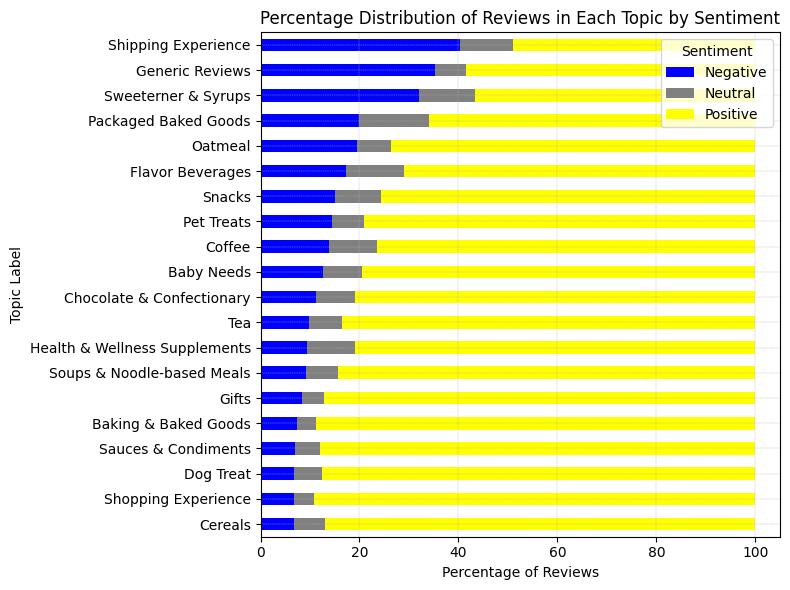

In [19]:
# 13. Plot Sentiment Distribution by Topic (in Percentage, Sorted by Negative Sentiment)
sent_table = df_sample.groupby(['Topic_Label', 'Sentiment']).size().unstack(fill_value=0)
sent_table_percent = sent_table.div(sent_table.sum(axis=1), axis=0) * 100
# Sort by percentage of negative sentiment in descending order
sent_table_percent = sent_table_percent.sort_values(by='Negative', ascending=False)

plt.figure(figsize=(8, 6))
sent_table_percent.plot(kind='barh', stacked=True, ax=plt.gca(), color=['blue', 'gray', 'yellow'])
plt.title('Percentage Distribution of Reviews in Each Topic by Sentiment')
plt.xlabel('Percentage of Reviews')
plt.ylabel('Topic Label')
plt.legend(title="Sentiment", loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [20]:
# 14. Plot LDA Topics (Bar Chart per Topic)
def get_top_words(model, feature_names, no_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return top_words

def plot_lda_topics(top_words, model, feature_names, no_top_words=10):
    n_topics = len(top_words)
    n_cols = 3
    n_rows = (n_topics + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 2 * n_rows), sharex='all')
    axes = axes.flatten()

    for i, (topic_idx, words) in enumerate(top_words.items()):
        indices = np.array([np.argwhere(feature_names == word)[0][0] for word in words])
        weights = model.components_[topic_idx][indices]
        sorted_indices = np.argsort(weights)[::-1]
        weights = weights[sorted_indices]
        words = np.array(words)[sorted_indices]
        ax = axes[i]
        ax.barh(words, weights, color='lightblue', height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}')
        ax.invert_yaxis()

    for j in range(i + 1, n_rows * n_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

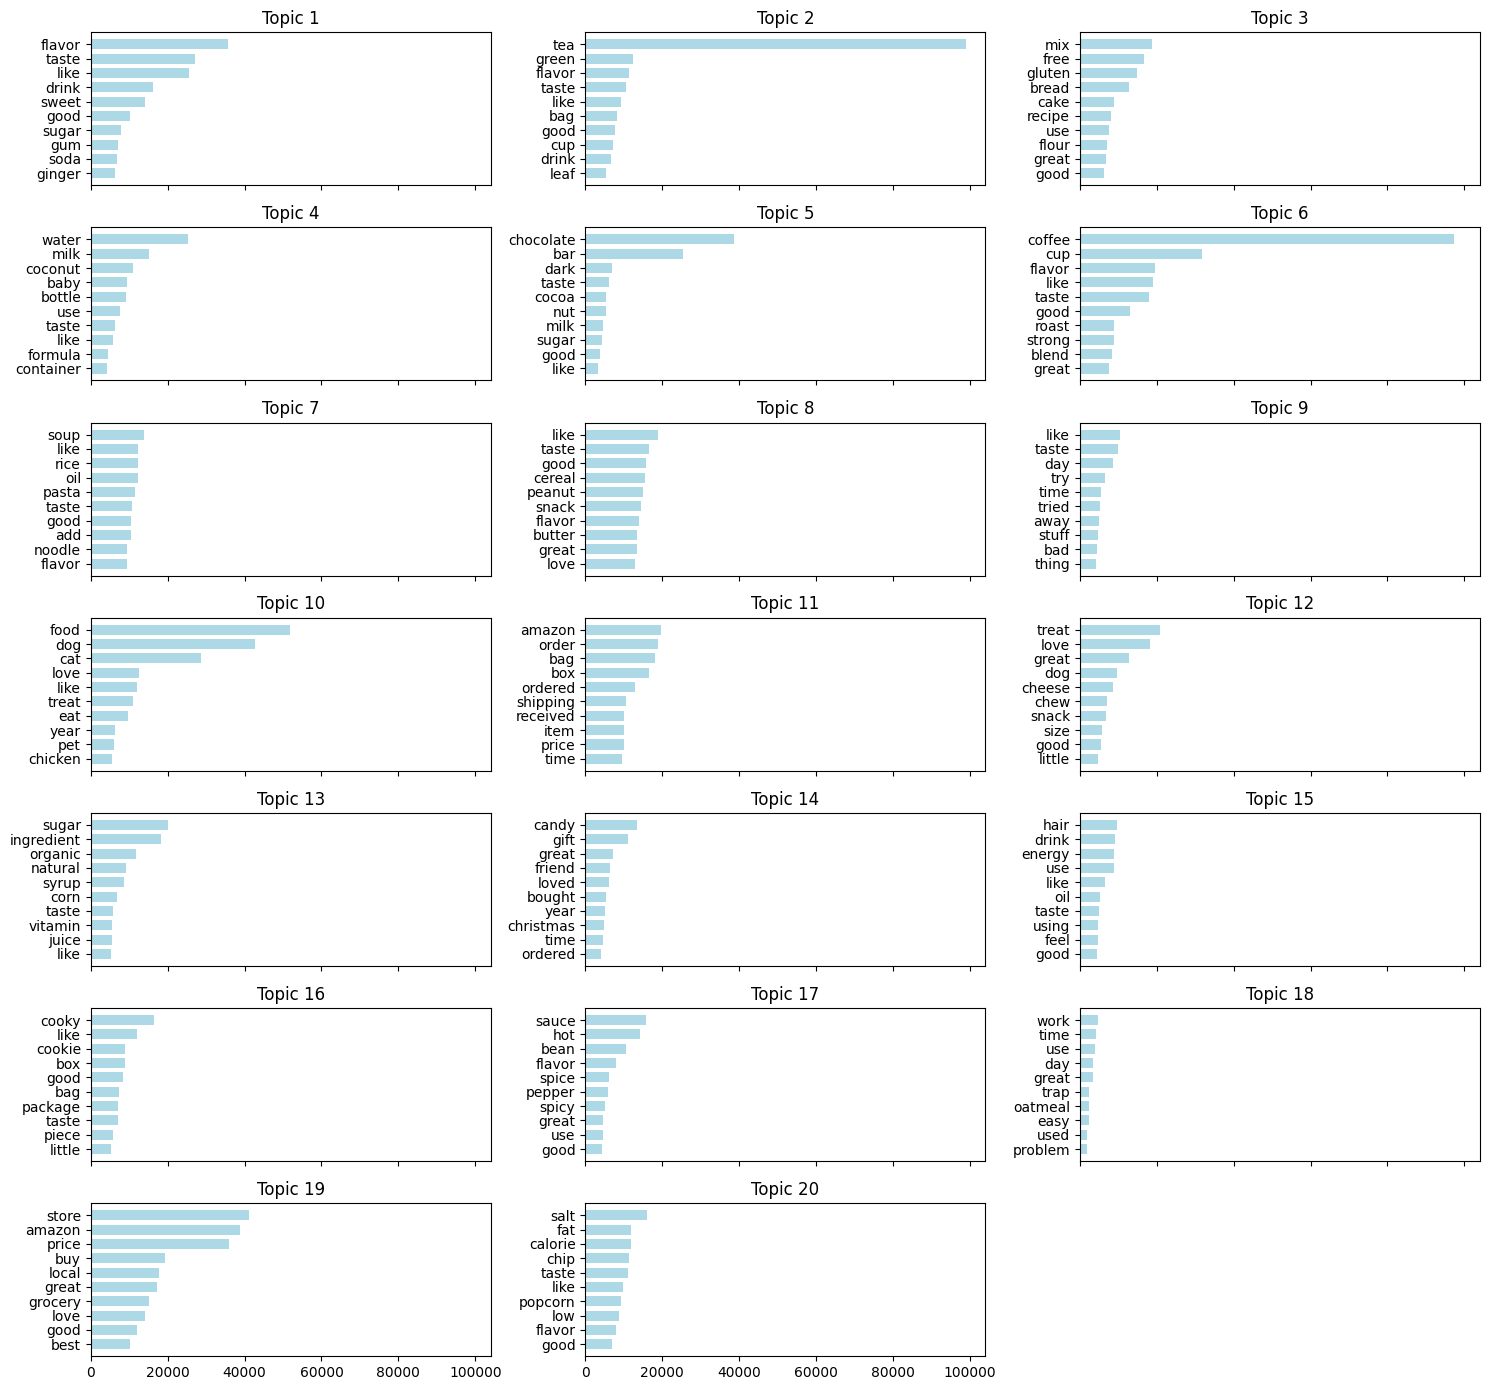

In [21]:
# Run the topic visualization
top_words = get_top_words(lda_exp2_20_model, feature_names, 10)
plot_lda_topics(top_words, lda_exp2_20_model, feature_names)

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

In [23]:
# Step 1: Use the same preprocessed texts
texts = df_sample['Processed_Text2'].apply(str.split).tolist()
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 2: Train a Gensim LDA model with same parameters (20 topics)
from gensim.models import LdaModel
gensim_lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=20,
                             random_state=42,
                             passes=10,
                             alpha='auto')

# Step 3: Visualize with pyLDAvis (Gensim version)
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(gensim_lda_model, corpus, dictionary)


In [24]:
pyLDAvis.save_html(vis_data, f"{base_dir}/lda_exp2_20topics_gensimvis.html")

In [25]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 99020
Number of documents: 390353


For Streamlit App

In [26]:
# import pickle
# import json
# import pandas as pd

# # === 1. Save the trained LDA model ===
# with open(f"{base_dir}/lda_exp2_20topics_model.pkl", "wb") as f:
#     pickle.dump(lda_exp2_20_model, f)

# # === 2. Save the fitted vectorizer ===
# with open(f"{base_dir}/vectorizer_exp2.pkl", "wb") as f:
#     pickle.dump(vectorizer_2, f)

# # === 3. Save top 10 keywords per topic as JSON ===
# def get_top_words_dict(model, feature_names, no_top_words=10):
#     top_words = {}
#     for topic_idx, topic in enumerate(model.components_):
#         top_words[f"Topic {topic_idx+1}"] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
#     return top_words

# feature_names = vectorizer_2.get_feature_names_out()
# top_words_dict = get_top_words_dict(lda_exp2_20_model, feature_names, 10)

# with open(f"{base_dir}/topic_keywords_exp2_20.json", "w") as f:
#     json.dump(top_words_dict, f, indent=4)

# # === 4. Save document-topic distribution ===
# doc_topic_dist = lda_exp2_20_model.transform(X2)
# doc_topic_df = pd.DataFrame(doc_topic_dist, columns=[f"Topic_{i+1}" for i in range(20)])
# doc_topic_df.to_csv(f"{base_dir}/doc_topic_distribution_exp2_20.csv", index=False)

# # === 5. Save full preprocessed dataset with topics and sentiment ===
# df_sample.to_csv(f"{base_dir}/preprocessed_reviews_with_topics.csv", index=False)


In [27]:
# from gensim.corpora import Dictionary
# texts = df_sample['Processed_Text2'].apply(str.split).tolist()
# dictionary = Dictionary(texts)


In [28]:
# # === 6. Save Gensim Dictionary ===
# dictionary.save(f"{base_dir}/lda_dictionary.dict")


In [29]:
# # === 7. Save Gensim Corpus (as MM format) ===
# from gensim import corpora
# corpora.MmCorpus.serialize(f"{base_dir}/lda_exp2_corpus.mm", corpus)

# # === 8. Save Dictionary as JSON for readability (optional) ===
# dict_json = {word_id: dictionary[word_id] for word_id in dictionary.keys()}
# with open(f"{base_dir}/lda_exp2_dictionary.json", "w") as f:
#     json.dump(dict_json, f, indent=4)